In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

In [2]:
from echogram import EchoGram

0it [00:00, ?it/s]

### October 2021 datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

## File:Sonar_2021-10-16_12.53.38 Speed=4mph

In [3]:
# Just run once to parse the sl2 file, then save the data of a variable in a file using pickle 
echo_4mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[5])

  0%|          | 0.00/415M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
print(echo_4mph_101621.df.head())

In [ ]:
print("echo shape:",echo_4mph_101621.echo.shape)
print("type(data):",type(echo_4mph_101621.echo))

In [ ]:
rows, cols = echo_4mph_101621.echo.shape
vmin=min(echo_4mph_101621.echo.flat)
vmax=max(echo_4mph_101621.echo.flat)
print("min intensity=",vmin)
print("max intensity=",vmax)

## Visualize image segments with "hot" colors

In [ ]:
plt.imshow(echo_4mph_101621.echo[:,int(cols/2):int(cols*2.8/5)], cmap='hot', vmin=vmin, vmax=vmax)
plt.colorbar()

In [ ]:
plt.imshow(echo_4mph_101621.echo[:,int(cols*9/10):-1],)
plt.colorbar()

In [ ]:
fig = plt.figure()
ax1 = echo_4mph_101621.df.plot.scatter(x="longitude", y="latitude")
echo_4mph_101621.df.loc[9600:10800,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax1)


In [ ]:
plt.imshow(echo_4mph_101621.echo[:,9600:10800], cmap='hot', vmin=vmin, vmax=vmax)

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

In [ ]:
echogram6mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])

In [ ]:
# with open('processed_data/echogram6mph_101621.txt', 'rb') as file:
#     # Call load method to deserialze
#     echogram6mph_101621 = pickle.load(file)
    
with open('processed_data/echogram6mph_101621.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(echogram6mph_101621, file)

In [ ]:
print("length:",len(echogram6mph_101621.data))
fig = plt.figure()
ax2 = echogram6mph_101621.df.plot.scatter(x="longitude", y="latitude")
echogram6mph_101621.df.loc[5600:6400,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2)

In [ ]:
plt.imshow(echogram6mph_101621.echo[:,5600:6400], cmap='hot')

## File:Sonar_2021-10-16_14.38.24 Speed=7mph

In [ ]:
echogram7mph_101621 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2', channels=[5])

In [ ]:
print("length:",len(echogram7mph_101621.data))
fig = plt.figure()
ax3 = echogram7mph_101621.df.plot.scatter(x="longitude", y="latitude")
echogram7mph_101621.df.loc[4400:5000,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax3)

In [ ]:
vmin=min(echogram7mph_101621.echo.flat)
vmax=max(echogram7mph_101621.echo.flat)
plt.imshow(echogram7mph_101621.echo[:,4400:5000], cmap='hot', vmin=vmin, vmax=vmax)

# DownScan Sonar

In [ ]:
downscan = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[2], depthline=False)

In [ ]:
plt.imshow(downscan.echo[:,9600:10800], cmap='hot')

## North-South and East-West comparisson

In [6]:
import os
files = os.listdir('log-data-lowrance/02_20_22')
print(files)

['Sonar_2022-01-20_16.16.03.sl2', 'Sonar_2022-01-20_10.45.23.sl2', 'Sonar_2022-01-20_09.53.33.sl2', 'Sonar_2022-01-20_15.54.19.sl2', 'Sonar_2022-01-20_11.05.09.sl2']


  0%|          | 0.00/417M [00:00<?, ?B/s]

  0%|          | 0.00/277M [00:00<?, ?B/s]

  0%|          | 0.00/194M [00:00<?, ?B/s]

  0%|          | 0.00/369M [00:00<?, ?B/s]

  0%|          | 0.00/431M [00:00<?, ?B/s]

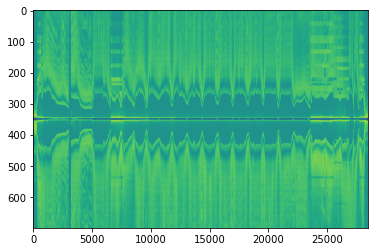

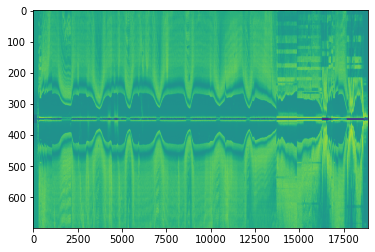

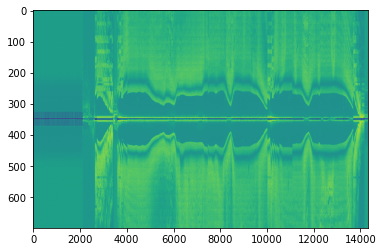

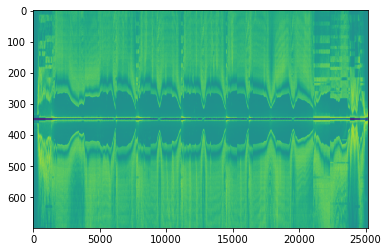

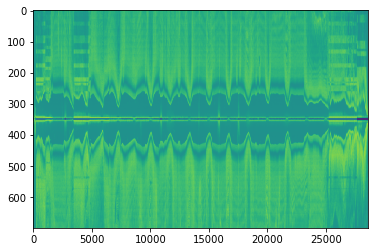

In [16]:
dataset_012022 = {}
for file in files:
    dataset_012022[file] = EchoGram('./log-data-lowrance/02_20_22/'+file, channels=[5])

In [30]:
# Run this to save the variables to a file
print("Checking the NO_SO variable exists. First element: ", NO_SO[0])
with open('processed_data/noso.txt', 'wb') as fl: 
    # A new file will be created
    pickle.dump(NO_SO, fl)
print("Checking the EA_WE variable exists. First element: ", EA_WE[0])   
with open('processed_data/eawe.txt', 'wb') as fl: 
    pickle.dump(EA_WE, fl)
print("Checking the dataset_012022 variable exists. Type: ", type(dataset_012022))   
with open('processed_data/dataset_012022.txt', 'wb') as fl:  
    pickle.dump(dataset_012022, fl)
print("Checking the cropped_dataset variable exists. Type: ", type(cropped_dataset))   
with open('processed_data/cropped_dataset.txt', 'wb') as fl:  
    pickle.dump(cropped_dataset, fl)

Checking the NO_SO variable exists. First element:  [11680, 12687, 0]
Checking the EA_WE variable exists. First element:  [   0 1300    1]
Checking the dataset_012022 variable exists. Type:  <class 'dict'>
Checking the cropped_dataset variable exists. Type:  <class 'dict'>
Checking the E_array variable exists. Type:  <class 'dict'>


In [4]:
# Run this to retrieve the variables from a file
with open('processed_data/noso.txt', 'rb') as fl:
    # Call load method to deserialze
    NO_SO = pickle.load(fl)
with open('processed_data/eawe.txt', 'rb') as fl:
    EA_WE = pickle.load(fl)
with open('processed_data/dataset_012022.txt', 'rb') as fl:
    dataset_012022 = pickle.load(fl)
with open('processed_data/cropped_dataset.txt', 'rb') as fl:
    cropped_dataset = pickle.load(fl)

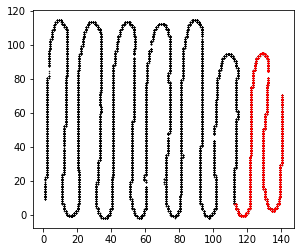

In [7]:
# Visualize and crop the datapoints that are garbage
start = 0
end = 3000
index_f = 0
#dataset_012022[files[index_f]].crop_data(start, end)
dataset_012022[files[index_f]].see_range([start,end])

xmin =  1.0033640917390585
xmax =  140.47097257710993
ymin =  -2.006728178821504
ymax =  114.38350624218583


<Figure size 432x288 with 0 Axes>

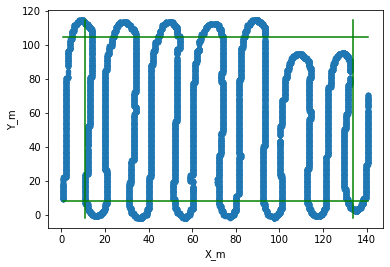

In [8]:
# approximate limits of axis for plotting
index_f = 0

xmin = dataset_012022[files[index_f]].df["X_m"].min()  # xmin =  1.0033640917390585
xmax = dataset_012022[files[index_f]].df["X_m"].max()  # xmax =  140.47097257710993
ymin = dataset_012022[files[index_f]].df["Y_m"].min()  # ymin =  -2.006728178821504
ymax = dataset_012022[files[index_f]].df["Y_m"].max()  # ymax =  114.38350624218583

print("xmin = ", xmin)
print("xmax = ", xmax)
print("ymin = ", ymin)
print("ymax = ", ymax)

fig = plt.figure()
ax2 = dataset_012022[files[index_f]].df.plot.scatter(x="X_m", y="Y_m")
ax2.plot([xmin+10]*2,[ymin,ymax], 'g') #xmin line
ax2.plot([xmax-7]*2,[ymin,ymax], 'g') #xmax line
ax2.plot([xmin,xmax],[ymin+10]*2, 'g') #ymin line
ax2.plot([xmin,xmax],[ymax-10]*2, 'g') #ymax line

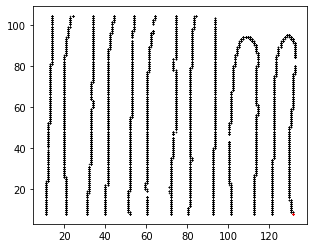

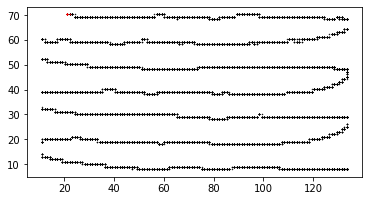

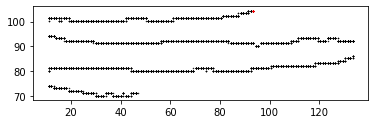

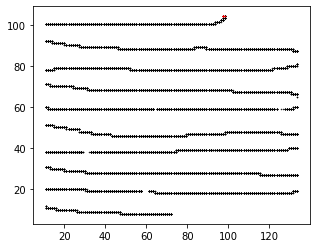

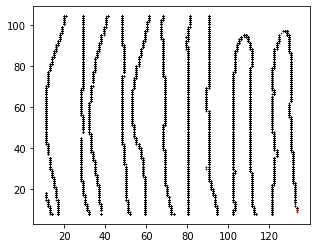

In [9]:
def select_and_crop_square(sonar_class):

    indexes = np.where(sonar_class.X < xmin+10)[0]
    indexes = np.concatenate((indexes, np.where(sonar_class.X > xmax-7)[0]))
    indexes = np.concatenate((indexes, np.where(sonar_class.Y < ymin+10)[0]))
    indexes = np.concatenate((indexes, np.where(sonar_class.Y > ymax-10)[0]))
    sonar_class.echo = np.delete(sonar_class.echo, indexes, 1)
    sonar_class.df = sonar_class.df.drop(sonar_class.df.index[indexes])
    sonar_class.X = np.delete(sonar_class.X, indexes)
    sonar_class.Y = np.delete(sonar_class.Y, indexes)

index_f = 0

for ii in range(len(files)):
    select_and_crop_square(cropped_dataset[files[ii]])
    
    cropped_dataset[files[ii]].see_range([0,10])

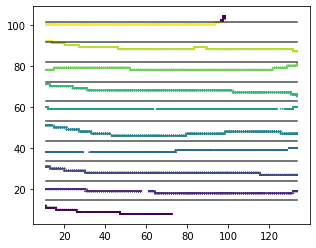

In [10]:
index_f = 3

def divide_and_conquer(sonar_class, nums, index_f, EA_WE):
    """Function that divides the raster patterns into lines by assuming lines are uniformly separated
    """
    maxxpo = sonar_class.X.max()
    minxpo = sonar_class.X.min()
    maxypo = sonar_class.Y.max()
    minypo = sonar_class.Y.min()
    
    dy = (maxypo - minypo)/nums
    index_dict = {} #dictionary is for not used idea of not having start end but all the indices
    start = np.copy(minypo) - 3
    end = start + dy + 0.1
    colors = np.zeros_like(sonar_class.Y)
    fig, ax = plt.subplots()
    eawe = np.array([[0, 0, 0]])
    for ii in range(nums):  # if statements to account for the drifts and non uniform rasters in the data
        if index_f == 1:
            if (ii == 5 or ii == 10):
                start += 4 
                end += 4 
        if index_f == 1:
            if (ii == 0 ):
                start += 1 
                end += 1
        if index_f == 2:
            if (ii == 0 ):
                start += 1 
                end += 1  
        indexes = np.where(sonar_class.Y > start)[0]
        index_dict[str(ii)] = np.where(sonar_class.Y[indexes] < end)[0]
        start += dy
        end += dy
        eawe = np.append(eawe, [[index_dict[str(ii)][0], index_dict[str(ii)][-1], index_f]], axis=0)
        colors[index_dict[str(ii)]] = ii
        ax.plot([minxpo,maxxpo], [start]*2, 'k', alpha=0.7) #xmax line
    
    ax.scatter(sonar_class.X, sonar_class.Y, c=colors, s=0.5)
    ax.set_aspect('equal')
    return eawe[1:-1]

ea_we1 = divide_and_conquer(cropped_dataset[files[index_f]], 10, index_f, EA_WE)
#EA_WE = np.concatenate((EA_WE, ea_we, ea_we1, ea_we2))  # join the ea_we datapoints of each files to a total matrix
#print("EA_WE: \n",EA_WE)

NO_SO= 
 [[11680, 12687, 0], [10668, 11679, 0], [9651, 10667, 0], [8668, 9650, 0], [7666, 8667, 0], [6676, 7665, 0], [5670, 6675, 0], [4708, 5669, 0], [3741, 4707, 0], [2910, 3740, 0], [1888, 2834, 0], [1016, 1887, 0], [0, 1000, 4], [1400, 2300, 4], [2400, 3400, 4], [3800, 4800, 4], [4900, 6100, 4], [6200, 7400, 4], [7500, 8600, 4], [10100, 11280, 4], [12600, 13870, 4]]


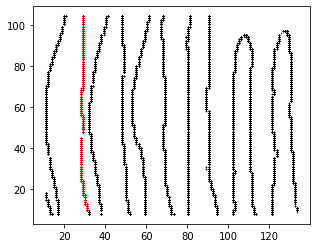

In [11]:
# Manually add the lines for the files where the raster pattern that are really non uniform

start= 12600
end = 13870
index_f = 4
cropped_dataset[files[index_f]].see_range([start,end])
NO_SO= [[11680, 12687, 0], 
 [10668, 11679, 0], 
 [ 9651, 10667, 0], 
 [ 8668,  9650, 0], 
 [ 7666,  8667, 0], 
 [ 6676,  7665, 0], 
 [ 5670,  6675, 0], 
 [ 4708,  5669, 0], 
 [ 3741,  4707, 0],  
 [ 2910,  3740, 0], 
 [ 1888,  2834, 0],  
 [ 1016,  1887, 0], 
 [ 0,  1000, 4], 
 [ 1400,  2300, 4], 
 [ 2400,  3400, 4], 
 [ 3800,  4800, 4], 
 [ 4900,  6100, 4], 
 [ 6200,  7400, 4],  
 [ 7500,  8600, 4], 
 [10100, 11280, 4], 
 [12600, 13870, 4]] 
# Uncomment to include line 
#NO_SO = np.append(NO_SO, [[start, end, index_f]], axis=0)
print("NO_SO= \n", NO_SO)

# Uncomment to include line 
#EA_WE = np.append(EA_WE, [[start, end, index_f]], axis=0)

In [79]:
def dir_comparison(no_so_model, no_so, ea_we_model, ea_we, is_plot=True):

    # Find index of minimumn distance between the average of two lines to start the search
    avg_lon_no_so = no_so_model.df['X_m'].to_numpy().mean()
    avg_lat_ea_we = ea_we_model.df['Y_m'].to_numpy().mean()
    ea_we_in_avg = np.argmin(np.abs(ea_we_model.df['X_m'].to_numpy()[ea_we]-avg_lon_no_so))
    no_so_in_avg = np.argmin(np.abs(no_so_model.df['Y_m'].to_numpy()[no_so]-avg_lat_ea_we))
    
    diffx = no_so_model.df['X_m'].to_numpy()[no_so[0]] - ea_we_model.df['X_m'].to_numpy()[ea_we[0]]
    diffy = no_so_model.df['Y_m'].to_numpy()[no_so[0]] - ea_we_model.df['Y_m'].to_numpy()[ea_we[0]]
    min_distance = np.sqrt(diffx**2 + diffy**2) 
    no_so_in = np.copy(no_so[no_so_in_avg])
    ea_we_in = np.copy(ea_we[ea_we_in_avg])

    # Define points close to the average intersection to search for real intersection
    dn_min = 0 if no_so_in_avg < 50 else 50
    de_min = 0 if ea_we_in < 50 else 50
    dn_max = len(no_so)-no_so_in_avg if no_so_in_avg+50 > len(no_so) else 50
    de_max = len(ea_we)-ea_we_in_avg if ea_we_in_avg+50 > len(ea_we) else 50
    
    # Run the intersection search to points close the average intersection (to not search for the entire run)
    nn = np.array(no_so[no_so_in_avg-dn_min:no_so_in_avg+dn_max])
    ee = np.array(ea_we[ea_we_in_avg-de_min:ea_we_in_avg+de_max])
    
    for ii in nn:
        for jj in ee:
            diffx = no_so_model.df['X_m'].to_numpy()[ii] - ea_we_model.df['X_m'].to_numpy()[jj]
            diffy = no_so_model.df['Y_m'].to_numpy()[ii] - ea_we_model.df['Y_m'].to_numpy()[jj]
            distance = np.sqrt(diffx**2 + diffy**2) 
            #print(ii, jj)
            if distance < min_distance:
                no_so_in = np.copy(ii)
                ea_we_in = np.copy(jj)
                #print('assign',no_so_in)
                #print('assign',ea_we_in)
                min_distance = np.copy(distance)    
    
    # Calculate difference in index to visualize the two paths intersecting
    diff_in = ea_we_in - no_so_in

    # Load depth values in cm
    no_so_depth = no_so_model.df['water_depth_m'].to_numpy()[no_so]*100
    ea_we_depth = ea_we_model.df['water_depth_m'].to_numpy()[ea_we]*100

    # return intersection 1 if there is an intersection (defined as less than the threshold)
    dist_threshold = 20
    is_crossing = 1 if min_distance < dist_threshold else 0
    
    # Exit function when there is no crossing or if points closer to the intersection are out of bounds of array
    poly_pts = 5 # half of number of points used to fir the polynomial
    if (no_so_in-poly_pts <= 0 or ea_we_in-poly_pts <= 0 or no_so_in+poly_pts >= max(no_so) or ea_we_in+poly_pts >= max(ea_we) or not is_crossing):
        if is_plot: # for debugging
            print(no_so_in-poly_pts <= 0)
            print(ea_we_in-poly_pts <= 0)
            print(ea_we_in+poly_pts >= max(ea_we))
            print(no_so_in+poly_pts >= max(no_so))
            print(not is_crossing)
            print("Distance between points: ", min_distance, "[cm]")
        return None, 0, None, None, None
    
    # Fit and generate a polynomial regressor to points close to intersection
    no_so_poly_in = np.arange(no_so_in-poly_pts, no_so_in+poly_pts) # indices
    ea_we_poly_in = np.arange(ea_we_in-poly_pts, ea_we_in+poly_pts) 
    no_so_poly = np.poly1d(np.polyfit(no_so_poly_in, no_so_model.df['water_depth_m'].to_numpy()[no_so_poly_in]*100, 3))
    ea_we_poly = np.poly1d(np.polyfit(ea_we_poly_in, ea_we_model.df['water_depth_m'].to_numpy()[ea_we_poly_in]*100, 3))    
    
    E1 = no_so_model.df['water_depth_m'].to_numpy()[no_so_in]*100 - ea_we_model.df['water_depth_m'].to_numpy()[ea_we_in]*100
    E = no_so_poly(no_so_in) - ea_we_poly(ea_we_in) # Difference of depth between lines
    #print("Ediff:", E1-E)
    
    x = no_so_model.df['X_m'].to_numpy()[no_so_in]
    y = no_so_model.df['Y_m'].to_numpy()[no_so_in]
    #x = ea_we_model.df['X_m'].to_numpy()[ea_we_in]
    #y = ea_we_model.df['Y_m'].to_numpy()[ea_we_in]
    if np.abs(E) > 50:
        is_large_E = True
    else:
        is_large_E = False
    
    if is_plot: 
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(np.array(no_so)+diff_in, no_so_depth, c='red', s=4, alpha=0.5, label='NS Sampled Points')
        ax.scatter(ea_we, ea_we_depth, c='gray', s=4, alpha=0.5, label='EW Sampled Points')
        #ax.plot(no_so_poly_in+diff_in, no_so_poly(no_so_poly_in), c='mediumblue',label='NS fitted polynomial')
        #ax.plot(ea_we_poly_in, ea_we_poly(ea_we_poly_in), c='firebrick', label='EW fitted polynomial')
        min_depth = np.min([np.min(no_so_depth), np.min(ea_we_depth)]) # get indices at edges of data range
        max_depth = np.max([np.max(no_so_depth), np.max(ea_we_depth)])
        ax.plot(np.array([no_so_in]*2)+diff_in,[min_depth,max_depth], '--y', label='Intersection')
        ax.set_ylabel('Depth [cm]')
        ax.set_xlabel('Data points')
        ax.legend()# use ' loc="lower right" ' to position legend
        plt.xlim((ea_we_in-50, ea_we_in+50))
        plt.ylim((ea_we_poly(ea_we_in)-15, ea_we_poly(ea_we_in)+15))
        plt.show()
        print("Error: ", E, "[cm]")
        print("Distance between points: ", min_distance, "[cm]")
        fig.savefig('paper_figures/comparisson2_yellow.png')#, dpi=fig.dpi

    return E, is_crossing, is_large_E, x, y

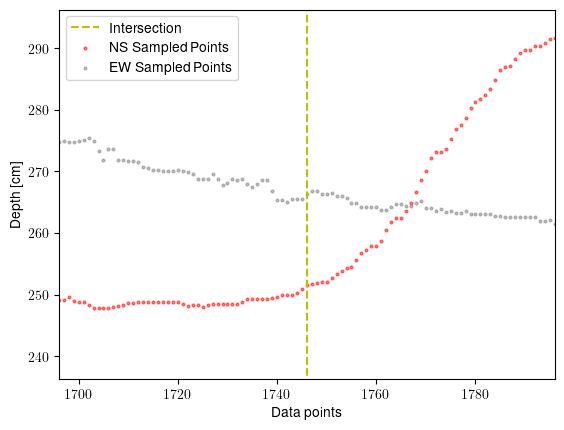

Error:  -14.978219255805016 [cm]
Distance between points:  29.373044593556738 [cm]


(-14.978219255805016, 1, False, 80.26912718825042, 59.19848129991442)

In [63]:
no_so1 = [ 6200,  7400, 4]  
ea_we1 = [ 1066,  2432,     3]
no_so_range1 = range(no_so1[0], no_so1[1])
ea_we_range1 = range(ea_we1[0], ea_we1[1])
dir_comparison(cropped_dataset[files[no_so1[2]]], no_so_range1, cropped_dataset[files[ea_we1[2]]], ea_we_range1, is_plot=True)

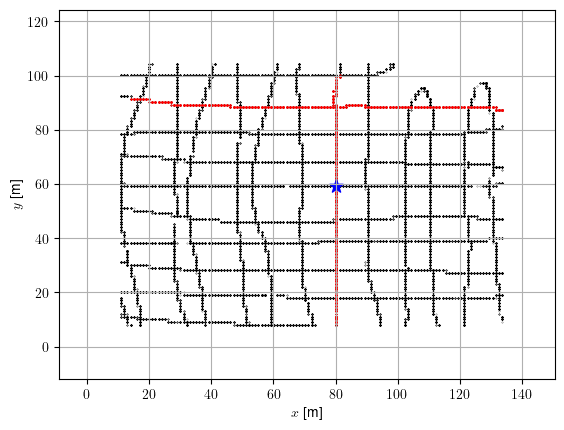

In [55]:
plt.style.use("default")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

fig, ax = plt.subplots()
ax.scatter(cropped_dataset[files[no_so1[2]]].X, cropped_dataset[files[no_so1[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[ea_we1[2]]].X, cropped_dataset[files[ea_we1[2]]].Y, c='k', s=0.05, alpha=0.8)  #.df['X_m'].to_numpy()
ax.scatter(cropped_dataset[files[no_so1[2]]].X[no_so_range1], cropped_dataset[files[no_so1[2]]].Y[no_so_range1], c='r', s=0.1, )
ax.scatter(cropped_dataset[files[ea_we1[2]]].X[ea_we_range1], cropped_dataset[files[ea_we1[2]]].Y[ea_we_range1], c='r', s=0.1)
plt.scatter(80.26912718825042, 59.19848129991442, s=100, marker="*", c='blue')
#ax.set_aspect('equal')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
plt.xlim(xmin-10, xmax+10)  
plt.ylim(ymin-10, ymax+10)
plt.grid()
plt.show()
fig.savefig('paper_figures/pattern1.jpg', dpi=fig.dpi)


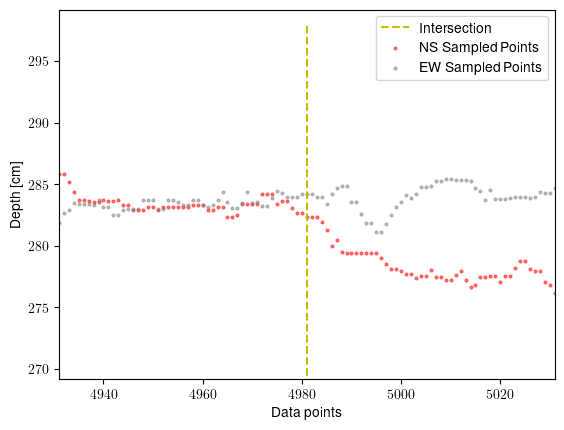

Error:  -1.6972347497940063 [cm]
Distance between points:  3.01009226962924 [cm]


(-1.6972347497940063, 1, False, 80.26912718825042, 39.13119950238615)

In [75]:
no_so2 = [ 6200,  7400, 4]  
ea_we2 = [ 4400,  5750,     1]
no_so_range2 = range(no_so2[0], no_so2[1])
ea_we_range2 = range(ea_we2[0], ea_we2[1])
dir_comparison(cropped_dataset[files[no_so2[2]]], no_so_range2, cropped_dataset[files[ea_we2[2]]], ea_we_range2, is_plot=True)

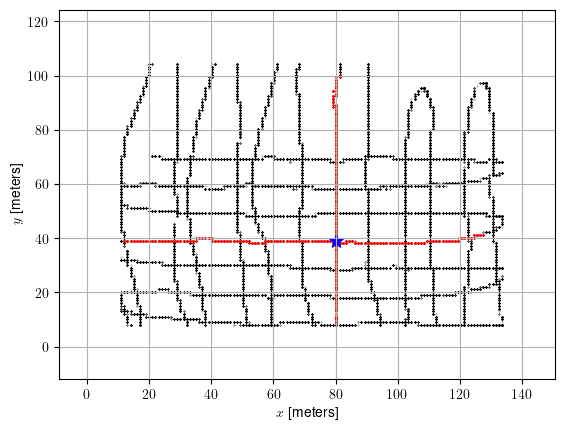

In [33]:
fig, ax = plt.subplots()
ax.scatter(cropped_dataset[files[no_so2[2]]].X, cropped_dataset[files[no_so2[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[ea_we2[2]]].X, cropped_dataset[files[ea_we2[2]]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[no_so2[2]]].X[no_so_range2], cropped_dataset[files[no_so2[2]]].Y[no_so_range2], c='r', s=0.1, )
ax.scatter(cropped_dataset[files[ea_we2[2]]].X[ea_we_range2], cropped_dataset[files[ea_we2[2]]].Y[ea_we_range2], c='r', s=0.1)
plt.scatter(80.26912718825042, 39.13119950238615, s=100, marker="*", c='blue')
#ax.set_aspect('equal')
ax.set_xlabel('$x$ [meters]')
ax.set_ylabel('$y$ [meters]')
plt.xlim(xmin-10, xmax+10)  
plt.ylim(ymin-10, ymax+10)
plt.grid()
plt.show()
fig.savefig('paper_figures/pattern2.jpg', dpi=fig.dpi)

In [34]:
# Save values to .mat file 
def to_mat():
    import scipy.io
    index_ns = 0  #0,4
    index_ew = 3  #1,2,3
    no_so_X_m = dataset_012022[files[index_ns]].df['X_m'].to_numpy()
    no_so_Y_m = dataset_012022[files[index_ns]].df['Y_m'].to_numpy()
    no_so_depth_m = dataset_012022[files[index_ns]].df['water_depth_m'].to_numpy()
    ea_we_X_m = dataset_012022[files[index_ew]].df['X_m'].to_numpy()
    ea_we_Y_m = dataset_012022[files[index_ew]].df['Y_m'].to_numpy()
    ea_we_depth_m = dataset_012022[files[index_ew]].df['water_depth_m'].to_numpy()
    data = {'no_so_X_m':no_so_X_m, 'no_so_Y_m':no_so_Y_m, 'no_so_depth_m':no_so_depth_m, 'ea_we_X_m':ea_we_X_m,'ea_we_Y_m':ea_we_Y_m, 'ea_we_depth_m':ea_we_depth_m} # 'no_so_X_m':no_so_X_m, 'no_so_Y_m':no_so_Y_m, 'no_so_depth_m':no_so_depth_m 
    scipy.io.savemat('data.mat', data)
        
to_mat()

Text(0.5, 0, 'Error [cm]')

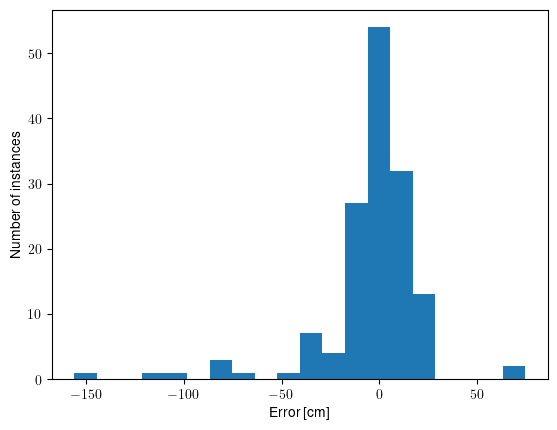

In [80]:
# Run comparisson algorithm for all combinations of intersection (including all files)
E_array = []
weird_x = []
weird_y = []
cross_x = []
cross_y = []
ii = 0
is_plot = False

for no_so in NO_SO:
    for ea_we in EA_WE:
        no_so_range = range(no_so[0], no_so[1])
        ea_we_range = range(ea_we[0], ea_we[1])
        E, is_crossing, is_large_E, x, y = dir_comparison(cropped_dataset[files[no_so[2]]], no_so_range,
                                      cropped_dataset[files[ea_we[2]]], ea_we_range, is_plot=False)
        E_array.append(E)
        # Removes the difference if the lines do not cross (distance more than threshold)
        if not is_crossing:
            E_array = E_array[:-1] 
        if is_large_E:
            weird_x.append(x)
            weird_y.append(y)
        cross_x.append(x)
        cross_y.append(y)
        
        if is_plot:
            print(ii)
            print("noso: ",no_so)
            print("eawe: ",ea_we)
            fig, ax = plt.subplots()
            ax.plot(cropped_dataset[files[no_so[2]]].X[no_so_range], cropped_dataset[files[no_so[2]]].Y[no_so_range], 'k', ms=0.5, )
            ax.plot(cropped_dataset[files[ea_we[2]]].X[ea_we_range], cropped_dataset[files[ea_we[2]]].Y[ea_we_range], 'ro', ms=0.5)
            ax.set_aspect('equal')
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.show()
            #time.sleep(2)
            ii +=1
del x, y

E_array = np.array(E_array)
plt.hist(E_array, bins=20)  
plt.ylabel('Number of instances')
plt.xlabel('Error [cm]')

In [82]:
print("Checking the E_array variable exists. Type: ", type(E_array))   
with open('processed_data/Error_histogram.txt', 'wb') as fl:  
    pickle.dump(E_array, fl)

Checking the E_array variable exists. Type:  <class 'numpy.ndarray'>


Total # of points:  144
Median:  0.8109502792358398
Mean:  -1.369780297068549
Standard Deviation:  19.984296363493897


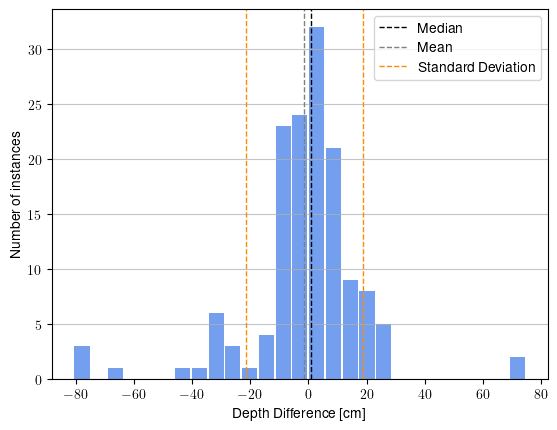

In [85]:
with open('processed_data/Error_histogram.txt', 'rb') as fl:
    E_array = pickle.load(fl)
    
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

print("Total # of points: ",len(E_array))
print("Median: ",np.median(E_array))
print("Mean: ",np.mean(E_array))
print("Standard Deviation: ",E_array.std())


fig, axes = plt.subplots()
n, bins, patches = plt.hist(x=E_array, bins='auto', color='cornflowerblue',
                            alpha=0.9, rwidth=0.9)
plt.axvline(np.median(E_array), color='k', linestyle='dashed', linewidth=1, label="Median")
plt.axvline(np.mean(E_array), color='gray', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(np.mean(E_array)+E_array.std(), color='darkorange', linestyle='dashed', linewidth=1, label="Standard Deviation")
plt.axvline(np.mean(E_array)-E_array.std(), color='darkorange', linestyle='dashed', linewidth=1, )
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Number of instances')
plt.xlabel('Depth Difference [cm]')
#plt.title('North-South and East West depth comparisson')
plt.legend()
plt.savefig('paper_figures/error_hist.png', dpi=fig.dpi)

In [ ]:
print('[')
for e in E_array:
    print(e,',')
print(']')

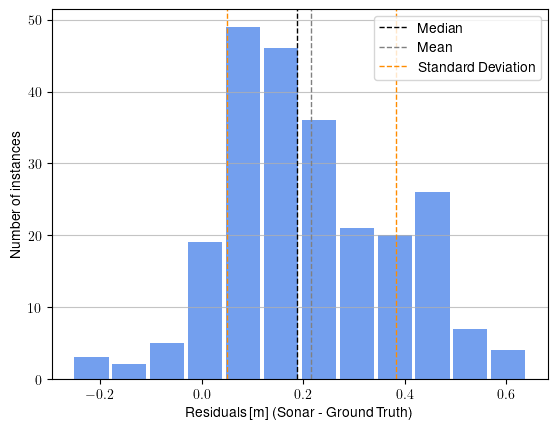

In [86]:
# Other histograms for the paper

df = pd.read_csv('AccuracyErrorTable.csv')
x = df['Error'].to_numpy()

fig, axes = plt.subplots()
n, bins, patches = plt.hist(x=x, bins='auto', color='cornflowerblue',
                            alpha=0.9, rwidth=0.9)
plt.axvline(np.median(x), color='k', linestyle='dashed', linewidth=1, label="Median")
plt.axvline(np.mean(x), color='gray', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(np.mean(x)+x.std(), color='darkorange', linestyle='dashed', linewidth=1, label="Standard Deviation")
plt.axvline(np.mean(x)-x.std(), color='darkorange', linestyle='dashed', linewidth=1, )
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Number of instances')
plt.xlabel('Residuals [m] (Sonar - Ground Truth)')
#plt.title('North-South and East West depth comparisson')
plt.legend()
plt.savefig('paper_figures/Tony_error_hist.png', dpi=fig.dpi)

Total # of points:  32


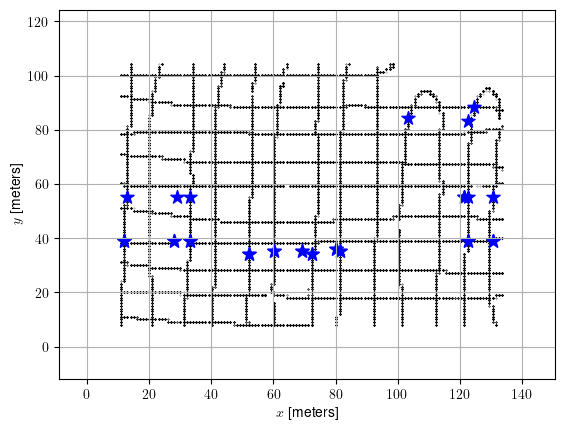

In [32]:
print("Total # of points: ",len(weird_y))

fig, ax = plt.subplots()
ax.scatter(cropped_dataset[files[3]].X, cropped_dataset[files[3]].Y, c='k', s=0.05, alpha=0.8)
ax.scatter(cropped_dataset[files[0]].X, cropped_dataset[files[0]].Y, c='k', s=0.05, alpha=0.8)
#ax.set_aspect('equal')
for ii in range(len(weird_x)):
    plt.scatter(weird_x[ii], weird_y[ii], s=100, marker="*", c='blue')
ax.set_xlabel('$x$ [meters]')
ax.set_ylabel('$y$ [meters]')
plt.xlim(xmin-10, xmax+10)  
plt.ylim(ymin-10, ymax+10)
plt.grid()
plt.show()